## CNN Binary Classification Model
In this notebook I make a convolutional neural network for binary classification of stock movements.  The goal is to input a stock chart created in the previous notebook and be able to determine if the stock will be higher or lower at the end of 10 trading days.  The metric of success for this endevour will be if it can make money when deployed on unseen data.  Getting 80% correct but being wrong on the biggest movers means that you can still lose money.  An important note is that the test data is more recent than the validation data which is more recent than the training data.  Because of the competitive and changing nature of markets, this set up eliminates the possibility that the model would benefit from "learning" on more recent charts and then applying that to older charts.

Here I import the necessary libraries along with the data created in the previous notebook.

In [183]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import accuracy_score
import keras
from keras import layers
from keras import models
from keras import optimizers
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
import pickle
import time
import datetime
from scipy import stats
from IPython.display import display, Math, Latex

pickle_in=open("x_train.pickle","rb")
x_train=pickle.load(pickle_in)
pickle_in=open("x_valid.pickle","rb")
x_valid=pickle.load(pickle_in)
pickle_in=open("x_test.pickle","rb")
x_test=pickle.load(pickle_in)
pickle_in=open("y_train.pickle","rb")
y_train=pickle.load(pickle_in)
pickle_in=open("y_valid.pickle","rb")
y_valid=pickle.load(pickle_in)
pickle_in=open("y_test.pickle","rb")
y_test=pickle.load(pickle_in)
pickle_in=open("invest_return_test.pickle","rb")
invest_return_test=pickle.load(pickle_in)
pickle_in=open("invest_return_valid.pickle","rb")
invest_return_valid=pickle.load(pickle_in)
pickle_in=open("invest_return_train.pickle","rb")
invest_return_train=pickle.load(pickle_in)
pickle_in=open("trade_dates.pickle","rb")
trade_dates=pickle.load(pickle_in)
pickle_in=open("ticker.pickle","rb")
ticker=pickle.load(pickle_in)
pickle_in=open("true_return_test.pickle","rb")
true_return_test=pickle.load(pickle_in)
pickle_in=open("true_return_valid.pickle","rb")
true_return_valid=pickle.load(pickle_in)
pickle_in=open("true_return_train.pickle","rb")
true_return_train=pickle.load(pickle_in)

Here I reshape the data to be input into the model.

In [16]:
TIME_RANGE=107
num_classes=2
# input image dimensions
img_rows, img_cols = TIME_RANGE, TIME_RANGE

x_train_mod = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_valid_mod = x_valid.reshape(x_valid.shape[0], img_rows, img_cols, 1)
x_test_mod = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (TIME_RANGE, TIME_RANGE, 1)

x_train_mod = x_train_mod.astype('float32')
x_valid_mod = x_valid_mod.astype('float32')
x_test_mod = x_test_mod.astype('float32')

x_train_mod = x_train_mod/255
x_valid_mod = x_valid_mod/255
x_test_mod = x_test_mod/255

print('x_train_mod shape:', x_train_mod.shape)
print('x_valid_mod shape:', x_valid_mod.shape)
print('x_test_mod shape:', x_test_mod.shape)
 
y_train_mod = keras.utils.to_categorical(y_train, num_classes)
y_valid_mod = keras.utils.to_categorical(y_valid, num_classes)
y_test_mod = keras.utils.to_categorical(y_test, num_classes)

x_train_mod shape: (8674, 107, 107, 1)
x_valid_mod shape: (1454, 107, 107, 1)
x_test_mod shape: (2350, 107, 107, 1)


Here I build, compile and train the model and subsequently use it to make predictions on unseen data.

In [17]:
batch_size =50
num_classes = 2
epochs = 3
 
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=input_shape, activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(10, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train_mod, y_train_mod,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_valid_mod, y_valid_mod))

# Make predictions on unseen data
predictions = model.predict(x_test_mod)

print(" ")
print('Percent of all unseen charts that went up: ',np.mean(y_test_mod[:,1]))
actuals = y_test_mod[:,1]
preds = predictions[:,1]
print ('Accuracy on test data:', accuracy_score(actuals,[1 if x >= 0.5 else 0 for x in preds]))
fpr, tpr, thresholds = roc_curve(y_test_mod[:,1], predictions[:,1])
roc_auc = auc(fpr, tpr)
print('Test AUC:',roc_auc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 105, 105, 64)      640       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 103, 103, 32)      18464     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 102, 102, 10)      1290      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 51, 51, 10)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 51, 51, 10)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 26010)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               3329408   
__________

As we can see, the stock went up 58.8% of the time but the model was only correct 54.8% of the time, meaning that simply guessing that every stock will go up everytime would be more accurate.  Furthermore, the area under the ROC curve is almost exactly 50, meaning that the model provides no insight beyond a random guess.  This seems like a pretty poor model but let's dive a little deeper and see if there is hidden value.

Below I create a dataframe, "pr", that has each trade's confidence of going up and down, the result and the amount that the stock moved.  In trading there are many ways to manage risk and one of them is to risk more money on trades you have more confidence in and to risk less on those that you are less sure about. The attribute "money" is a trade's percent return if you had taken it in the direction suggested (buy if predicted to go up and sell short if predicted to go down). The attribute "weighted money" is the return if you risked more on trades that the model is more confident in.  The weighting goes from 1 to potentially 5 shares.

In [19]:
pr=pd.DataFrame(predictions,columns=['lower','higher'])
real=pd.DataFrame(y_test_mod[:,1],columns=['real'])
pr=pr.merge(real,left_index=True,right_index=True)
ret=pd.DataFrame(true_return_test,columns=['pct_return'])
pr=pr.merge(ret,left_index=True,right_index=True)
money=[]
weighted_money=[]
trade_size=[]
for i in range(len(pr)):
    if pr.higher[i]>=.5:
        money.append(pr.pct_return[i])
        weighted_money.append((int(pr.higher[i]*10)-4)*pr.pct_return[i])
        trade_size.append(int(pr.higher[i]*10)-4)
    else:
        money.append(-pr.pct_return[i])
        weighted_money.append((int(pr.lower[i]*10)-4)*-pr.pct_return[i])
        trade_size.append(int(pr.lower[i]*10)-4)
money=pd.DataFrame(money,columns=['money'])
weighted_money=pd.DataFrame(weighted_money,columns=['weighted_money'])
trade_size=pd.DataFrame(trade_size,columns=['trade_size'])
pr=pr.merge(money,left_index=True,right_index=True)
pr=pr.merge(weighted_money,left_index=True,right_index=True)
pr=pr.merge(trade_size,left_index=True,right_index=True)
trade_dates=pd.DataFrame(trade_dates,columns=['trade_dates'])
#ticker=pd.DataFrame(ticker,columns=['ticker'])
pr=pr.merge(trade_dates,left_index=True,right_index=True)
#pr=pr.merge(ticker,left_index=True,right_index=True)
pr['pred']=round(pr.higher,0)
pr['correct_y_n']=-(np.abs(pr.pred-pr.real)-1)

Here I will chart various performance metrics against the percent chance that the model gave the stock of moving up.  One particular thing to note is the "risk_compare" metric that I create.  A value greater than 1 indicates that the selected trades are adding risk adjusted return compared with taking all trades with equal risk.

W0717 20:07:20.267273 16780 legend.py:1289] No handles with labels found to put in legend.
W0717 20:07:20.276267 16780 legend.py:1289] No handles with labels found to put in legend.


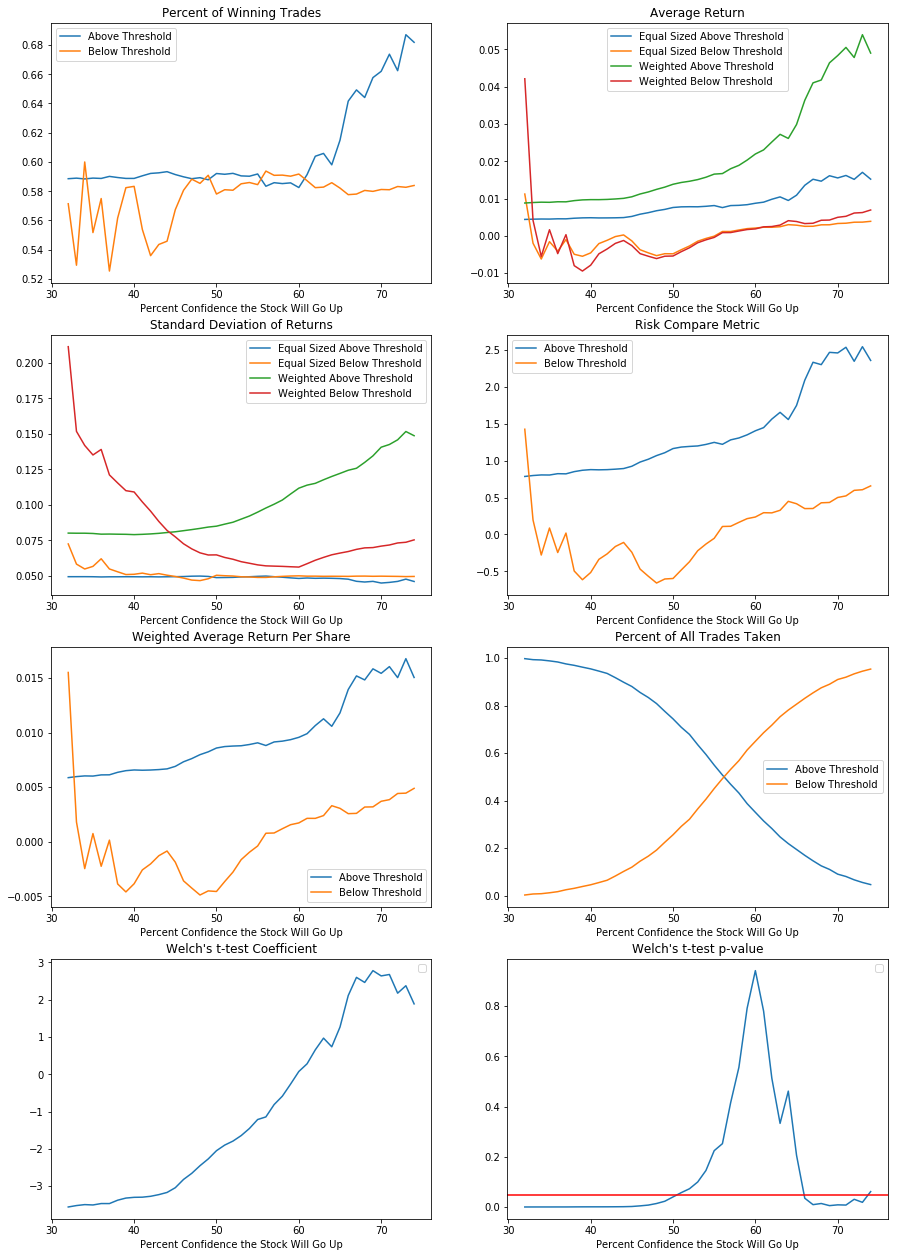

In [198]:
pct_winner=[]
eq_avg_return=[]
eq_std=[]
weighted_avg_return=[]
weighted_std=[]
weighted_avg_return_per_share=[]
all_trades_avg_return=[]
all_trades_std=[]
risk_compare=[]
pct_trades_taken=[]
t_test=[]
p_value=[]
slice_thresh=[]
pct_winner2=[]
eq_avg_return2=[]
eq_std2=[]
weighted_avg_return2=[]
weighted_std2=[]
weighted_avg_return_per_share2=[]
all_trades_avg_return2=[]
all_trades_std2=[]
risk_compare2=[]
pct_trades_taken2=[]
t_test2=[]
p_value2=[]
weighted_up_all_trades=pr.pct_return*(holder.trade_size.mean())
for i in range(32,75):
    temp=pr[pr.higher>(i/100)]
    temp2=pr[pr.higher<(i/100)]
    pct_winner.append(temp.real.mean())
    eq_avg_return.append(temp.money.mean())
    eq_std.append(temp.money.std())
    weighted_avg_return.append(temp.weighted_money.mean())
    weighted_std.append(temp.weighted_money.std())
    weighted_avg_return_per_share.append(temp.weighted_money.mean()/temp.trade_size.mean())
    all_trades_avg_return.append(pr.pct_return.mean())
    all_trades_std.append(pr.pct_return.std())
    risk_compare.append((temp.weighted_money.mean()/pr.pct_return.mean())/(temp.weighted_money.std()/pr.pct_return.std()))
    pct_trades_taken.append((len(temp)/len(pr)))
    slice_thresh.append(i)
    t_test_results = stats.ttest_ind(temp.weighted_money,weighted_up_all_trades, equal_var=False)
    t_test.append(t_test_results[0])
    p_value.append(t_test_results[1])
    pct_winner2.append(temp2.real.mean())
    eq_avg_return2.append(temp2.money.mean())
    eq_std2.append(temp2.money.std())
    weighted_avg_return2.append(temp2.weighted_money.mean())
    weighted_std2.append(temp2.weighted_money.std())
    weighted_avg_return_per_share2.append(temp2.weighted_money.mean()/temp2.trade_size.mean())
    all_trades_avg_return2.append(pr.pct_return.mean())
    all_trades_std2.append(pr.pct_return.std())
    risk_compare2.append((temp2.weighted_money.mean()/pr.pct_return.mean())/(temp2.weighted_money.std()/pr.pct_return.std()))
    pct_trades_taken2.append((len(temp2)/len(pr)))
    t_test_results2 = stats.ttest_ind(temp.weighted_money,weighted_up_all_trades, equal_var=False)
    t_test2.append(t_test_results2[0])
    p_value2.append(t_test_results2[1])
fig = plt.figure(figsize=(15,22))
plt.subplot(4, 2, 1)
plt.plot(slice_thresh,pct_winner,label='Above Threshold')
plt.plot(slice_thresh,pct_winner2,label='Below Threshold')
plt.title('Percent of Winning Trades')
plt.xlabel('Percent Confidence the Stock Will Go Up')
plt.legend()
plt.subplot(4, 2, 2)
plt.plot(slice_thresh,eq_avg_return,label='Equal Sized Above Threshold')
plt.plot(slice_thresh,eq_avg_return2,label='Equal Sized Below Threshold')
plt.plot(slice_thresh,weighted_avg_return,label='Weighted Above Threshold')
plt.plot(slice_thresh,weighted_avg_return2,label='Weighted Below Threshold')
plt.legend()
plt.xlabel('Percent Confidence the Stock Will Go Up')
plt.title('Average Return')
plt.subplot(4, 2, 3)
plt.plot(slice_thresh,eq_std,label='Equal Sized Above Threshold')
plt.plot(slice_thresh,eq_std2,label='Equal Sized Below Threshold')
plt.plot(slice_thresh,weighted_std,label='Weighted Above Threshold')
plt.plot(slice_thresh,weighted_std2,label='Weighted Below Threshold')
plt.legend()
plt.xlabel('Percent Confidence the Stock Will Go Up')
plt.title('Standard Deviation of Returns')
plt.subplot(4, 2, 4)
plt.plot(slice_thresh,risk_compare,label='Above Threshold')
plt.plot(slice_thresh,risk_compare2,label='Below Threshold')
plt.legend()
plt.xlabel('Percent Confidence the Stock Will Go Up')
plt.title('Risk Compare Metric')
plt.subplot(4, 2,5)
plt.plot(slice_thresh,weighted_avg_return_per_share,label='Above Threshold')
plt.plot(slice_thresh,weighted_avg_return_per_share2,label='Below Threshold')
plt.legend()
plt.xlabel('Percent Confidence the Stock Will Go Up')
plt.title('Weighted Average Return Per Share')
plt.subplot(4, 2, 6)
plt.plot(slice_thresh,pct_trades_taken,label='Above Threshold')
plt.plot(slice_thresh,pct_trades_taken2,label='Below Threshold')
plt.legend()
plt.xlabel('Percent Confidence the Stock Will Go Up')
plt.title('Percent of All Trades Taken')
plt.subplot(4, 2, 7)
plt.plot(slice_thresh,t_test)
plt.legend()
plt.xlabel('Percent Confidence the Stock Will Go Up')
plt.title("Welch's t-test Coefficient")
plt.subplot(4, 2, 8)
plt.plot(slice_thresh,p_value)
plt.legend()
plt.xlabel('Percent Confidence the Stock Will Go Up')
plt.axhline(.05,color='red')
plt.title("Welch's t-test p-value")
plt.show()

## Some thoughts on the charts:
#### Row 1 Left Chart: 
From the blue line We see a clear trend of increased percentage of winning trades as the model's confidence increases.  We see the mirror trend in the orange line that as the maximum confidence sampled decreases, so does the percentage of winning trades.
#### Row 1 Right Chart:
The blue and green lines show that as the confidence increases, so does the average return.  The red and orange lines show the mirror that as confidence decreases, so does the average return with the exception of some outliers.
#### Row 2 Left Chart:
As we would expect, the red and green lines show that as the trades become more heavily weighted, so too do the standard deviations of their returns.  Interestingly the blue line decreases slightly above 65, which makes sense because as the percent of winners increases, there will be fewer negative returns to expand the standard deviation.
#### Row 2 Right Chart:
In my view this is the most informative chart.  The risk metric quantifies how much value the model is adding and we can clearly see that risk adjusted return increases as the model's confidence increases.
#### Row 3 Left Chart:
This chart standardizes all of the weighted trades so that we are looking at returns on equal risk.  This shows that the model identifies better trades and does not simply benefit from "betting more."
#### Row 3 Right Chart:
This chart is to highlight that while it might seem like a great idea to only take trades with 75% confidence, there are not many trades like that and so an optimal balance needs to be reached.
#### Row 4 Left Chart:
This depicts the t-test coefficient for the isolated trades compared with all trades.  Not surprisingly, the coefficient increases as the confidence goes up.
#### Row 4 Right Chart:
This is the p-value describing statistical significance and we can conclude that values under .05 (the red line) are significant.  This shows that the isolated trades with confidences on the extremes are different in a statistically significant way.

## Applying this to trading:
From the charts above we can clearly see that the model provides value in identifying trades to take.  Below I will extrapolate how that might play out in a real world trading scenerio.  For this we will only be considering taking buy trades because the usefulness of the model seems to be in the bullish direction.  For threshold level, I identify all available trades and which of those trades would be taken on each day and make that into a dataframe.  The "comp" attribute is the composite of all of the stocks in the Dow Jones Industrial Average and is the performance of the broad market which is the benchmark that we will compare our portfolio against.  Our weighted portfolio risks the same amount of money each day as the "comp" portfolio but the allocation of risk is based on which stocks the model has chosen and which weights it has assigned to those stocks.

Text(0, 0.5, 'Percent Improvement')

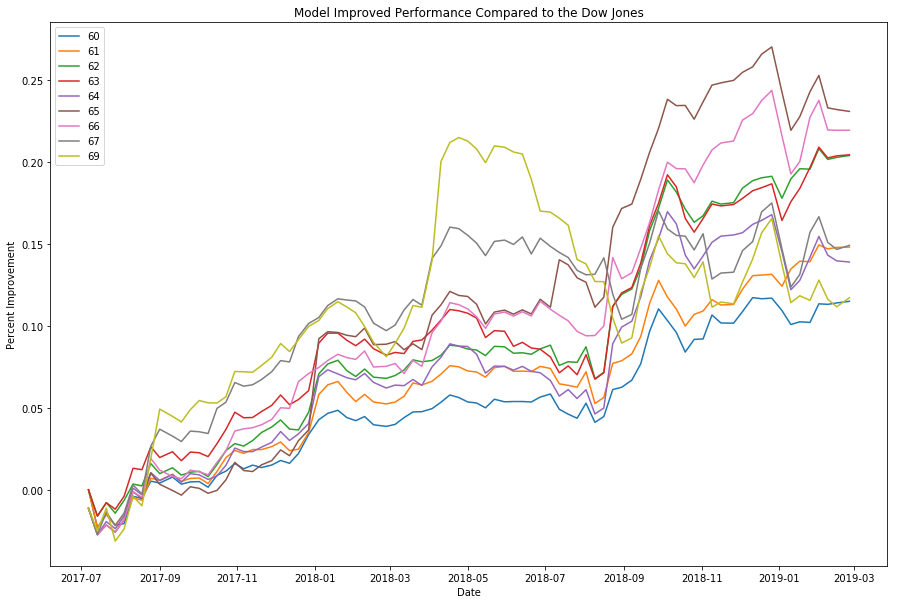

In [200]:
thresh_compare=pd.DataFrame([])
trade_dates=pr.trade_dates.unique()
num_dates=len(trade_dates)-1
thresh_compare['date']=trade_dates
made_it=[]
min_value_added=.1
for i in range(50,75):
    portfolio2=pd.DataFrame([])
    taken_trades=pr[pr.higher>(i/100)]
    for day in trade_dates:
        r=pr[pr.trade_dates==day]
        q=taken_trades[taken_trades.trade_dates==day]
        if len(q)>0:
            t=q.weighted_money.sum()/q.trade_size.sum()
        else:
            t=0
        # values are divided by two because each trade is a 10 day hold but new trades are entered
        # after 5 days. this means that half of the money is invested each entry day
        portfolio2=portfolio2.append(pd.DataFrame({'date':day,'port':t/2,
                                                'comp':r.pct_return.mean()/2},index=[0]),ignore_index=True)
    portfolio2['reinvest_port']=(1+portfolio2.port).cumprod()-1
    portfolio2['reinvest_comp']=(1+portfolio2.comp).cumprod()-1
    to_merge=portfolio2.reinvest_port-portfolio2.reinvest_comp
    if to_merge[num_dates]>min_value_added:
        thresh_compare['_'+str(i)]=to_merge
        made_it.append(i)
    else:
        None
plt.figure(figsize=(15,10))
for i in made_it:
    plt.plot(thresh_compare.date,thresh_compare['_'+str(i)],label=str(i))
plt.legend()
plt.title('Model Improved Performance Compared to the Dow Jones')
plt.xlabel('Date')
plt.ylabel('Percent Improvement')

The chart above isolates threshold levels that add at least a 10% improvement over the Dow Jones.  From this we can gather that any value between 60 and 70% will yield good results but it looks like 65% is the clear winner, both because of the highest ending value and it appears to be pretty consistant.  Lets take a look at the 65% level against the Dow Jones.

DJI Sharpe:  18.21
Portfolio Sharpe:  29.68


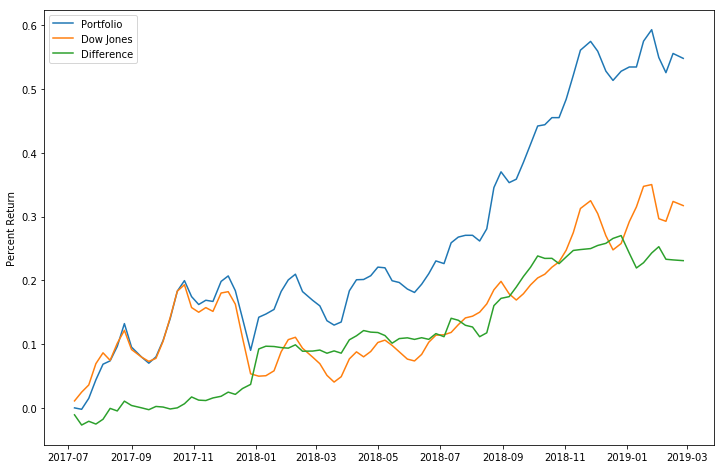

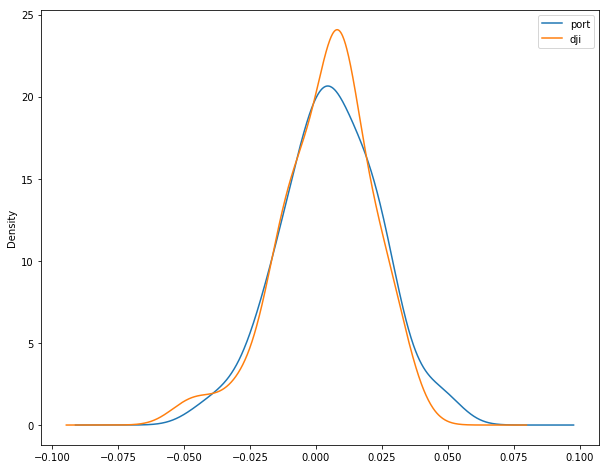

Coefficient:  0.708
p-value:  0.48


In [202]:
portfolio=pd.DataFrame([])
best=pr[pr.higher>(.65)]
for day in trade_dates:
    r=pr[pr.trade_dates==day]
    q=best[best.trade_dates==day]
    if len(q)>0:
        t=q.weighted_money.sum()/q.trade_size.sum()
    else:
        t=0
    portfolio=portfolio.append(pd.DataFrame({'date':day,'port':t/2,
                                            'comp':r.pct_return.mean()/2},index=[0]),ignore_index=True)
portfolio['reinvest_port']=(1+portfolio.port).cumprod()-1
portfolio['reinvest_comp']=(1+portfolio.comp).cumprod()-1
plt.figure(figsize=(12,8))
plt.plot(portfolio.date,portfolio.reinvest_port,label='Portfolio')
plt.plot(portfolio.date,portfolio.reinvest_comp,label='Dow Jones')
plt.plot(portfolio.date,portfolio.reinvest_port-portfolio.reinvest_comp,label='Difference')
plt.legend()
plt.ylabel('Percent Return')
print('DJI Sharpe: ',round(portfolio.reinvest_comp[len(portfolio)-1]/portfolio.comp.std(),2))
print('Portfolio Sharpe: ',round(portfolio.reinvest_port[len(portfolio)-1]/portfolio.port.std(),2))
plt.figure(figsize=(10, 8))
portfolio.port.plot.kde(label='port')
portfolio.comp.plot.kde(label='dji')
plt.legend()
plt.show()
t_test_results = stats.ttest_ind(portfolio.port,portfolio.comp, equal_var=False)
print('Coefficient: ',round(t_test_results[0],3))
print('p-value: ',round(t_test_results[1],3))

## Conclusions

In finance, the Sharpe Ratio is a standard metric of risk adjusted return and we can see that our portfolio has a dramatically higher Sharpe Ratio than the Dow Jones. This can be seen visually in the upper chart we can see that our portfolio dramatically outperforms the Dow Jones but there are some interesting details to note.  The first is that the green difference line shows a large spike in early 2018 which coincided with a very steep decline in US stocks.  This is a very telling thing because it means that our model picks the best stocks even in very unfavorable and unexpected market conditions.  The other interesting detail is that the green difference line rose dramatically but less steeply starting round August 2018.  This is meaningful because this was a time that the Dow Jones was steadily rising and even breaking into new record highs, meaning that when the whole market is rising, our model still outperforms. 

The lower chart are Kernel Density Estimation plots for the daily returns of our portfolio and for the Dow Jones.  The positive Welch's t-test coefficient is as expected but the p-value is much too high for the daily returns to be considered different in a statistically significant way.  However, the real world trading results are a very compelling marker of the value added by the model.

## Further Inqury
Before this concept could responsibly be deployed in live trading there would need to be significant improvements to the model including but not limited to:
- Using many more stock charts to train the model, including from companies that have been removed from the Dow Jones or have went bankrupt in order to avoid survivorship bias.
- Use more detailed images and optimize the amount of days included in each chart.
- Include more data in each chart such as volume and other technical indicators.